In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import warnings
warnings.filterwarnings("ignore")

In [2]:
url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
data=pd.read_csv(url, dtype={'fips':str})
data['location']=data.county+','+data.state
data['date'] = pd.to_datetime(data['date'])  

In [3]:
state_codes=pd.read_csv('abbr-name.csv', header=None)
state_codes.columns=['abbr', 'state']

In [4]:
def organize_data(df):
    df=df.sort_values(['state', 'county','date'], ascending=[1,1,1])
    return df

def get_state(df,state_name='Maryland'):
    state_df=df[df.state==state_name].reset_index().drop(columns=['index'], axis=0)
    return state_df


def get_state_agg(df,state_name):
    agg_df=df.groupby(['date']).sum()
    agg_df['state']=state_name
    return agg_df

def get_county(df,county_name='Baltimore city'):
    county_df=df[df.county==county_name].reset_index().drop(columns=['index'], axis=0)
    return county_df

def get_this(df,state_name='Maryland', county=False, county_name='Baltimore city'):
    if county==False:
        df_out=get_state_agg(get_state(df,state_name), state_name).reset_index()
    if county==True:
        df_out=get_county(get_state(df,state_name), county_name)
    return df_out

def get_date(df,start='2020-05-30', end='2020-05-30'):
    mask = (df['date'] >= start) & (df['date'] <= end)
    date_df=df[mask]
    return date_df

def plot_daily(df, county=True):
    #Given a dataframe, plot the daily increase.
    df['SM7']=df.daily.rolling(window=7).mean()
    df['SM14']=df.daily.rolling(window=14).mean()
    a,b=np.polyfit(df.index,df.daily,deg=1)
    plt.figure(figsize=(8,6))
    plt.plot(df.date, df.daily, marker='.', label='daily')
    plt.plot(df.date, np.ones(len(df))*df.daily.mean(), label='total avg')
    plt.plot(df.date, df.index*a+b, label='trend')
    plt.plot(df.date, df.SM14, label='SM14')
    plt.plot(df.date, df.SM7, label='SM7')
    plt.legend(loc='best')
    plt.xticks(rotation=45, fontsize=12)
    plt.ylim([0,max(df.daily)*1.05])
    if county==True:
        plt.title(str(df.county.unique())+', '+str(df.state.unique()))
    else:
        plt.title(str(df.state.unique()))
    plt.show()

def local_cases(data, ff_dct):
    for i in list(ff_dct.keys()):
        plot_daily(get_this(data,state_name=ff_dct[i], 
                            county=True, county_name=i))
        plt.show()

In [5]:
states_list=list(state_codes.abbr.unique())
data['abbr']=data['state']
for i in range(len(states_list)):
    data['abbr'].replace(state_codes.loc[i]['state'], 
                         state_codes.loc[i]['abbr'], inplace=True)
data['daily']=data['cases']
data=organize_data(data)


for i in range(len(data)-1):
    if i==0: 
        data.daily.iloc[i]=data.cases.iloc[i]
    else:
        if data.county.iloc[i]!= data.county.iloc[i-1]:
            data.daily.iloc[i]=data.cases.iloc[i]
        else:
            data.daily.iloc[i] =data.cases.iloc[i]-data.cases.iloc[i-1]
    if  data.daily.iloc[i]<0:
        data.daily.iloc[i]=0

C:\Users\Mark\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\Mark\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


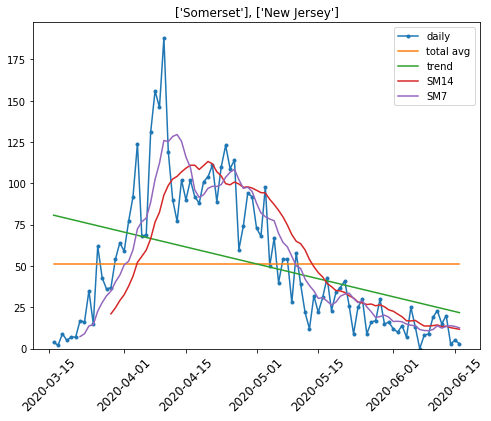

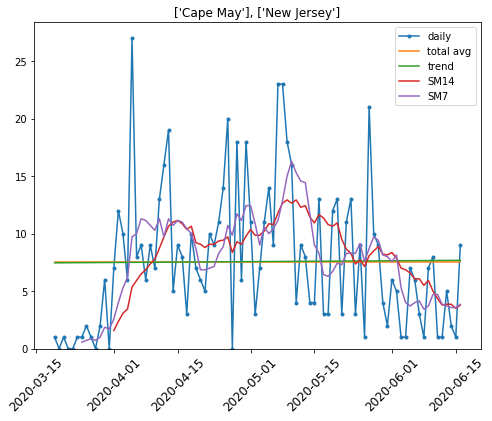

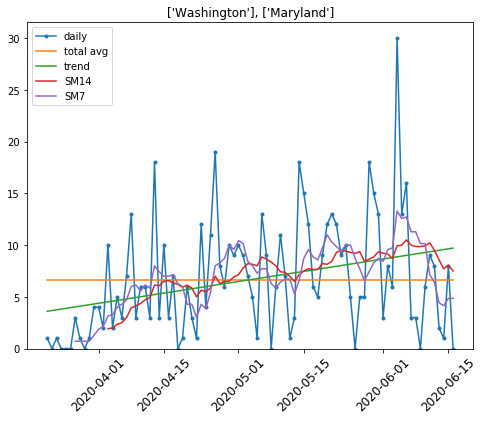

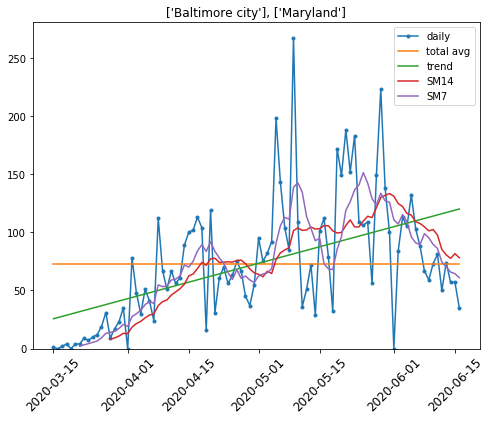

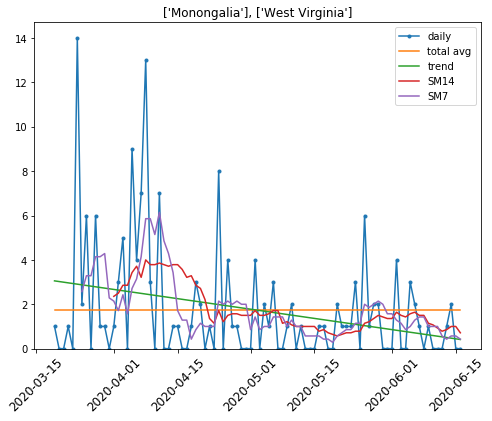

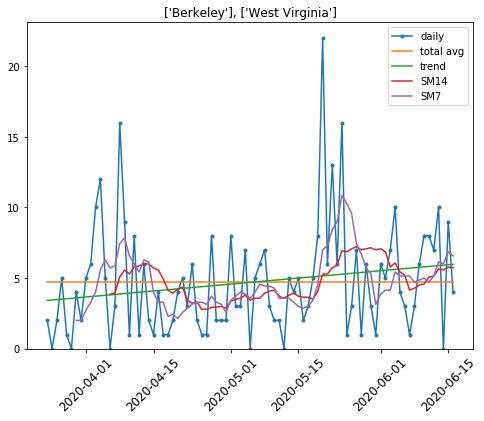

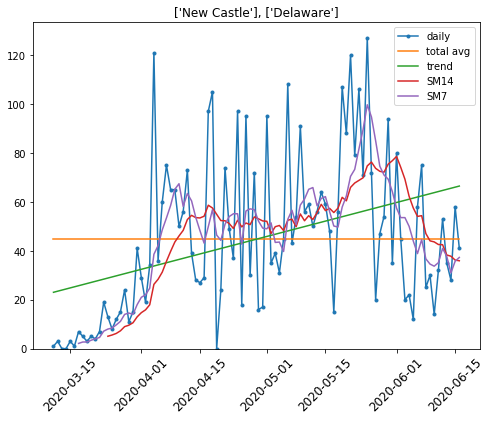

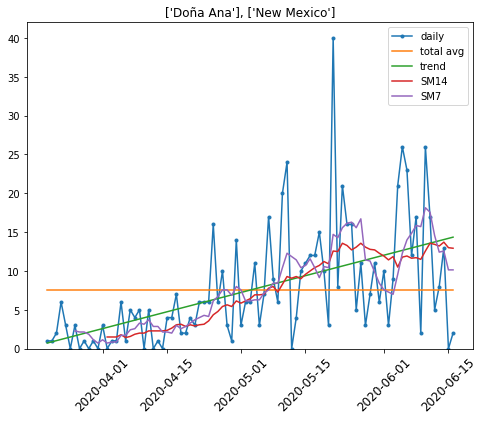

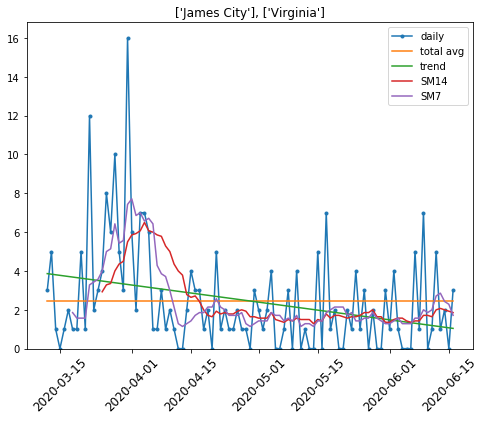

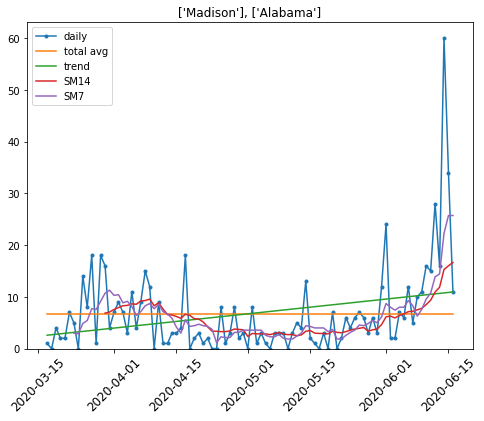

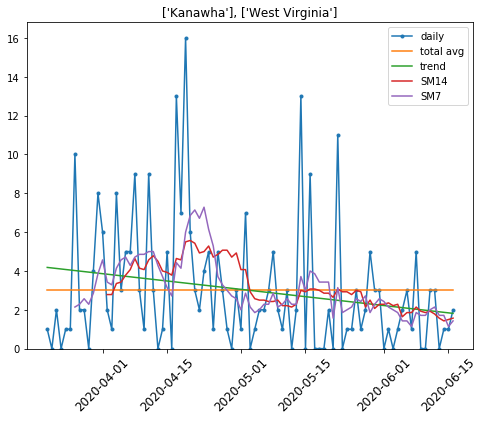

In [6]:
ff_dct={'Somerset':'New Jersey', 
        'Cape May':'New Jersey',
        'Washington':'Maryland', 
        'Baltimore city':'Maryland', 
        'Monongalia':'West Virginia', 
        'Berkeley':'West Virginia', 
        'New Castle':'Delaware', 
        'Doña Ana':'New Mexico', 
        'James City':'Virginia',
        'Madison':'Alabama',
        'Kanawha': 'West Virginia'}
local_cases(data,ff_dct)

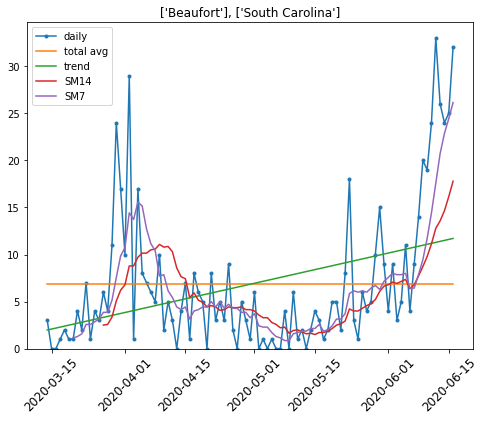

In [7]:
plot_daily(get_this(data,state_name='South Carolina', 
                    county=True, county_name='Beaufort'), county=True)